<a href="https://colab.research.google.com/github/JoaoCioffi/Kagglin/blob/main/Seattle_Temp_Forecast/Seattle_Temperature_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

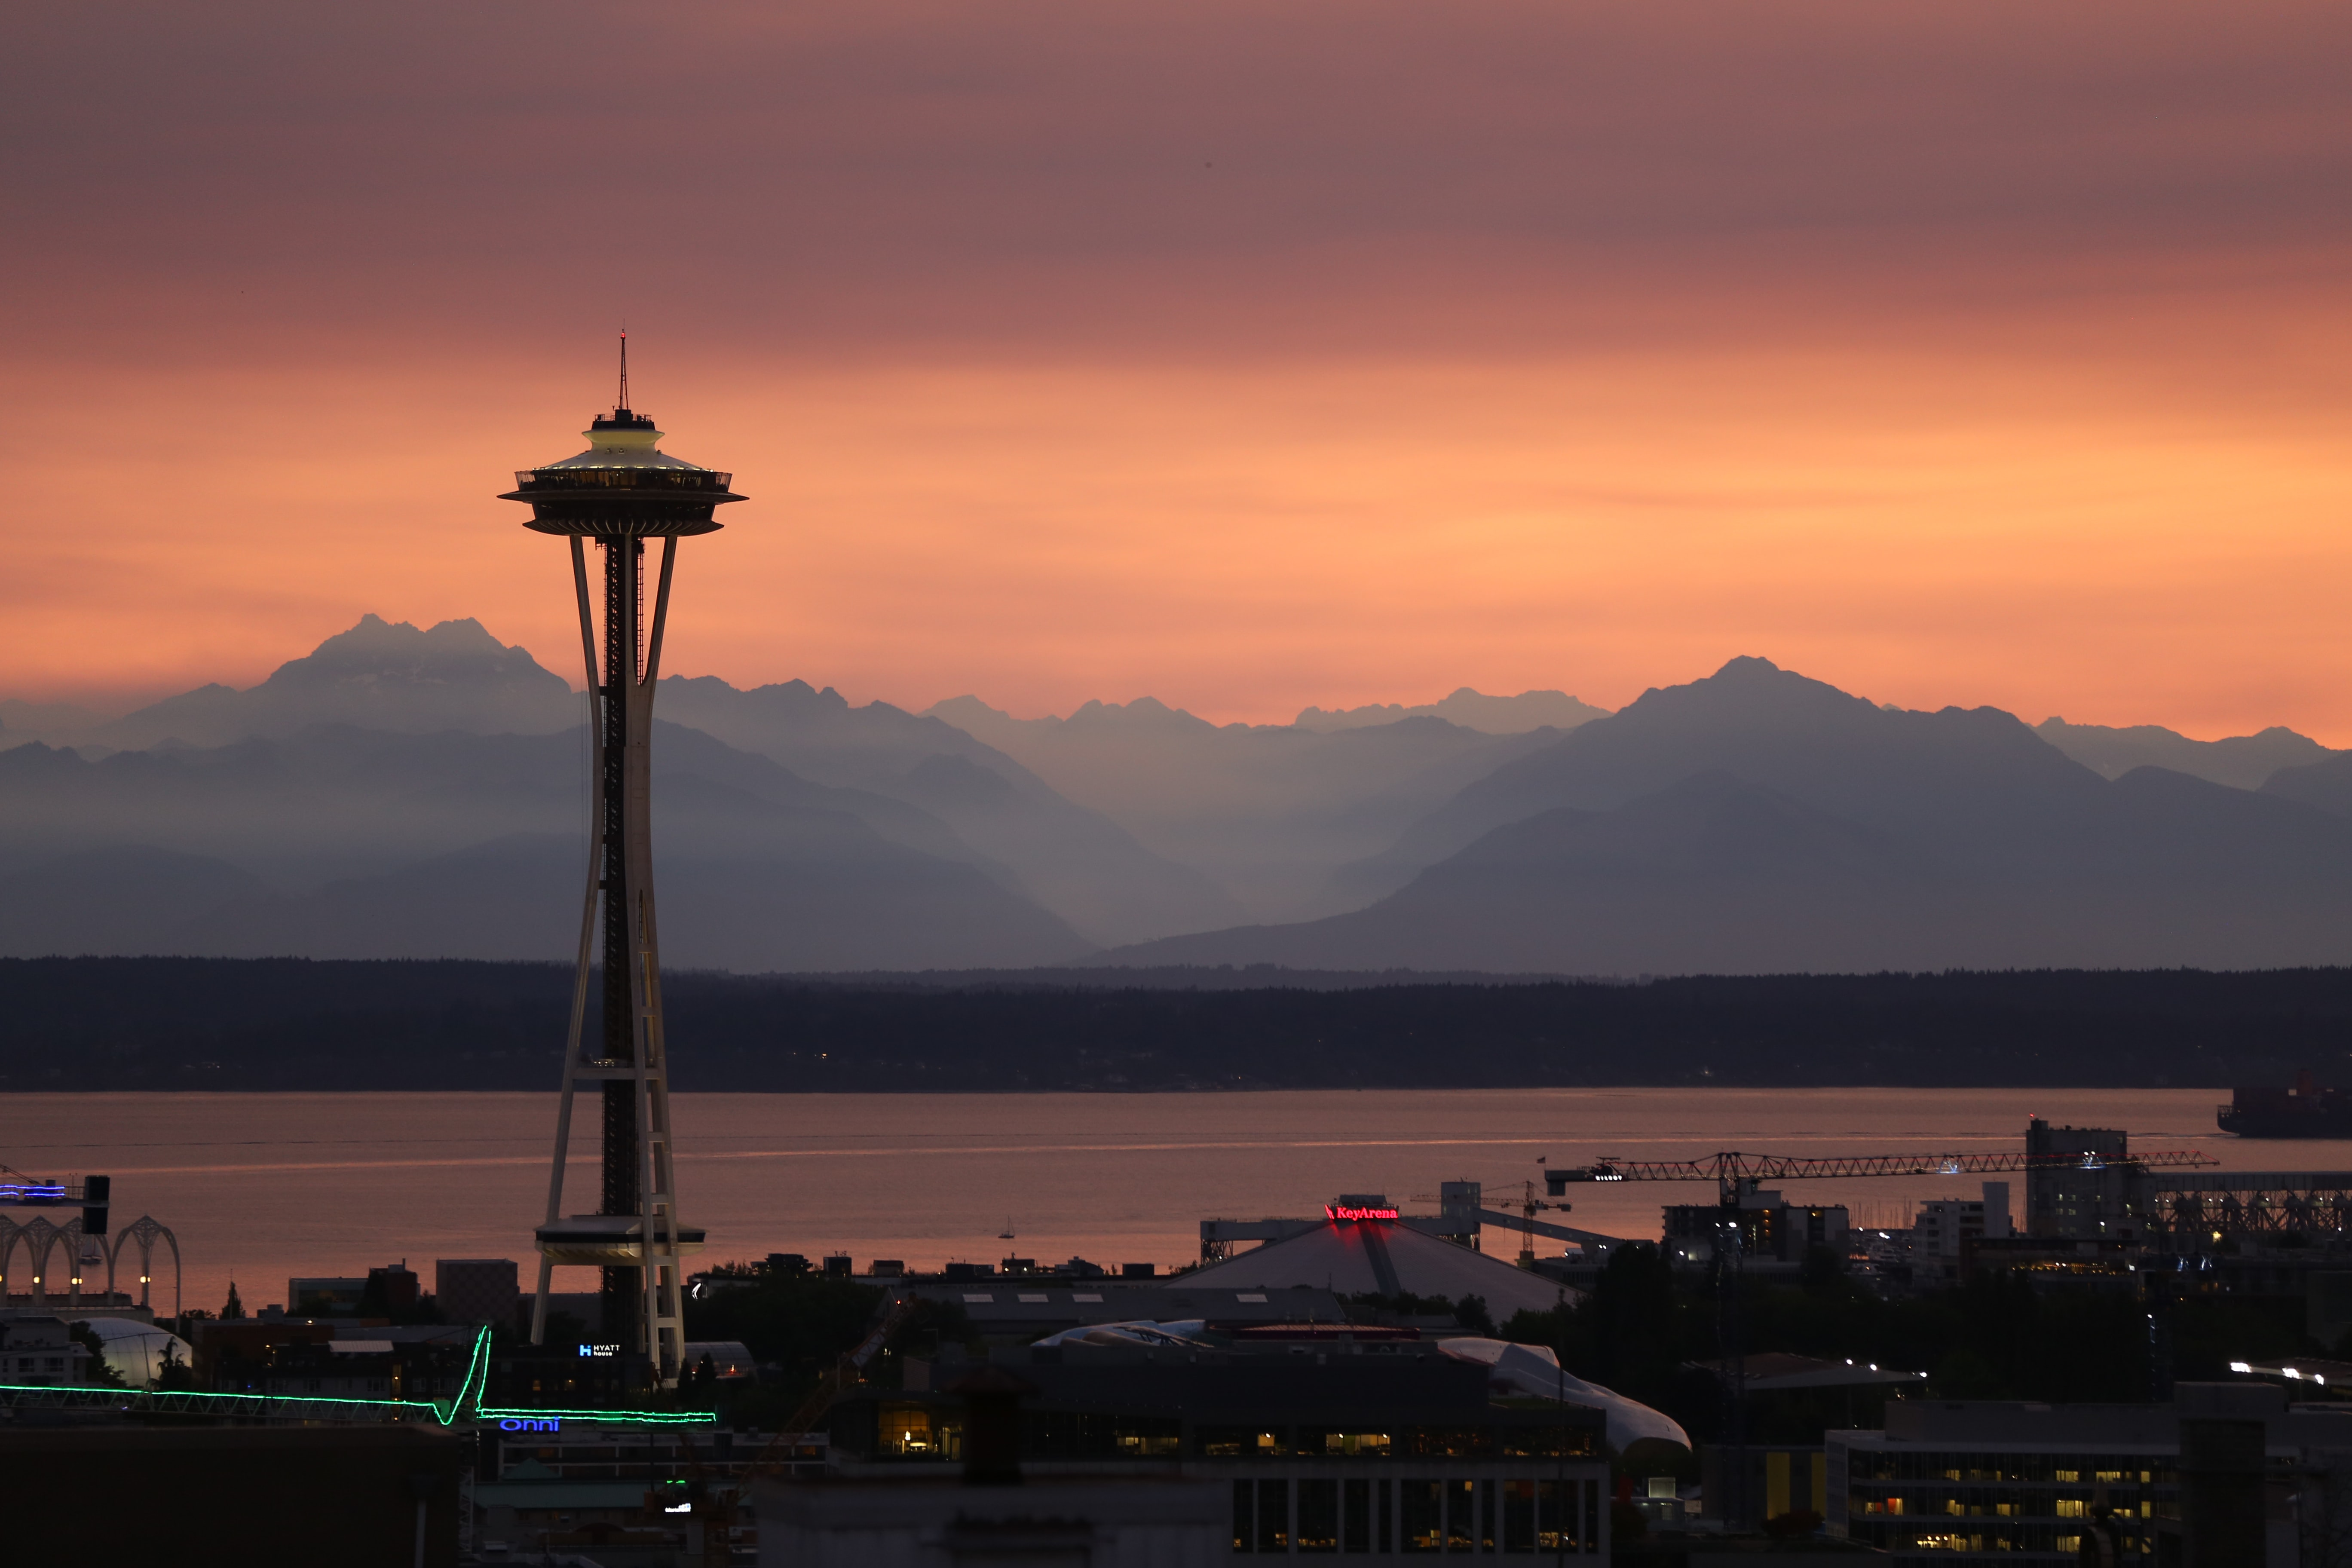

# Introdução ao Problema:

> Neste estudo de caso faremos a modelagem para prever a máxima temperatura para o dia seguinte na cidade de Seattle-WA utilizando a base de dados NOAA (https://www.ncdc.noaa.gov/cdo-web/). Neste aspecto temos acesso ao histórico das temperaturas máximas registradas ao longo dos anos (série temporal), as temperaturas registradas nos últimos dois dias e uma variável estimada através de previsões de tempo comuns.

> O caso em questão será modelado através de um algoritmo supervisionado (problema de regressão), pois temos o histórico tanto das features quanto do target (temperaturas) que precisamos prever. Além disso, esta é uma tarefa de regressão devido ao fato de os valores para o nosso target são numéricos contínuos (isto é, não são números inteiros que designam classes distintas como em problemas de classificação).

> Roadmap
>> Antes de irmos direto à programação, devemos estabelecer um breve guia para nos manter no caminho certo. As etapas a seguir formam a base para qualquer workflow de machine learning assim que tivermos um problema e um modelo em mente:
1. Declarar a pergunta do problema e determinar os dados necessários;
2. Adquirir os dados em um formato acessível;
3. Identificar e corrijir os pontos/anomalias de dados ausentes conforme necessário;
4. Preparar os dados para o modelo;
5. Estabelecer um baseline model que você pretende superar;
6. Treinar o modelo nos dados de treinamento;
7. Fazer previsões sobre os dados de teste;
8. Comparar as previsões com as metas conhecidas do conjunto de testes e calcular as métricas de desempenho;
9. Se o desempenho não for satisfatório, ajustar o modelo, adquirir ou criar mais dados (feature engineering) ou ainda tentar uma técnica de modelagem diferente;
10. Interpretar o modelo e relatar os resultados visualmente e/ou numericamente;

>> Além disso, esse workflow pode ser complementado com uma das frameworks mais utilizadas no cenário de data science, que é o CRISP-DM:
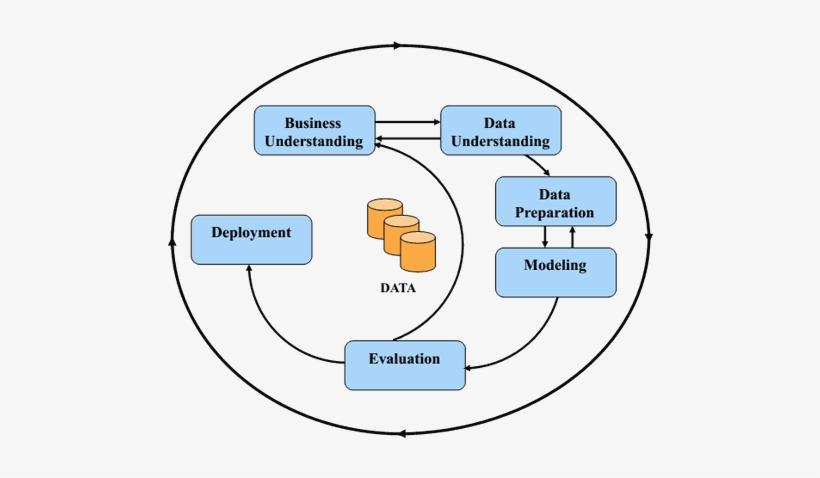


> Aquisição dos dados:
>> Para usar um exemplo realista, tomaremos como base dados meteorológicos registrados em Seattle de 2011~2017 através do NOAA Climate Data Online. Geralmente, cerca de 80% do tempo gasto na análise de dados é para limpar e recuperar dados, mas essa carga de trabalho pode ser reduzida ao encontrar fontes de dados de alta qualidade. A ferramenta NOAA é surpreendentemente fácil de usar e os dados de temperatura podem ser baixados como arquivos csv limpos que podem ser analisados em linguagens como Python ou R. O arquivo de dados completo está disponível para download para aqueles que desejam acompanhar: https://drive.google.com/file/d/1pko9oRmCllAxipZoa3aoztGZfPAD2iwj/view


# 1- Main Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2- Loading Data

> Main DF

In [2]:
url = 'https://raw.githubusercontent.com/JoaoCioffi/Kagglin/main/Seattle_Temp_Forecast/temps.csv'
df = pd.read_csv(url)
df

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39
...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2016,12,28,Wed,15.21,0.05,0,42,44,45.3,47,30
2187,2016,12,29,Thurs,8.72,0.00,0,44,47,45.3,48,63
2188,2016,12,30,Fri,8.50,0.05,0,47,48,45.4,45,57
2189,2016,12,31,Sat,6.93,0.02,0,48,45,45.5,38,56


> Nulls Quantity

In [3]:
df.isna().sum()

year       0
month      0
day        0
weekday    0
ws_1       0
prcp_1     0
snwd_1     0
temp_2     0
temp_1     0
average    0
actual     0
friend     0
dtype: int64

> Info

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     2191 non-null   int64  
 1   month    2191 non-null   int64  
 2   day      2191 non-null   int64  
 3   weekday  2191 non-null   object 
 4   ws_1     2191 non-null   float64
 5   prcp_1   2191 non-null   float64
 6   snwd_1   2191 non-null   int64  
 7   temp_2   2191 non-null   int64  
 8   temp_1   2191 non-null   int64  
 9   average  2191 non-null   float64
 10  actual   2191 non-null   int64  
 11  friend   2191 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 205.5+ KB


> Metadata DF

In [5]:
Metadata_characters_raw = pd.DataFrame({'Var':list(df.columns),
                                        'Dtype':list(df.dtypes), 
                                        'Explanation':['number for the year',
                                                       'number for month of the year',
                                                       'number for day of the year',
                                                       'day of the week as a character string',
                                                       'prior wind speed',
                                                       'prior precipitation',
                                                       'prior snow depth',
                                                       'max temperature 2 days prior (F)',
                                                       'max temperature 1 day prior (F)',
                                                       'historical average max temperature (F)',
                                                       'max temperature measurement (F) - this is our target',
                                                       'a friend’s prediction, a random number between 20 below the average and 20 above the average'],
                                        'Nuniques':list(df.nunique())})
Metadata_characters_raw

,Var,Dtype,Explanation,Nuniques
0,year,int64,number for the year,7
1,month,int64,number for month of the year,12
2,day,int64,number for day of the year,31
3,weekday,object,day of the week as a character string,7
4,ws_1,float64,prior wind speed,81
5,prcp_1,float64,prior precipitation,121
6,snwd_1,int64,prior snow depth,4
7,temp_2,int64,max temperature 2 days prior (F),68
8,temp_1,int64,max temperature 1 day prior (F),68
9,average,float64,historical average max temperature (F),250


Fazer um Metadata das nossas variáveis é uma etapa bem importante para prosseguir tanto com as análises descritivas quanto com o modelo de ML. Nessa etapa iremos desconsiderar os valores da coluna 'friend', pois nosso problema é justamente o de prever a temperatura atual olhando para as demais variáveis e não queremos que o modelo 'dependa' de previsões externas

# 3- Exploratory Data Analysis (EDA)

> Estatísticas Gerais

In [6]:
round(df.drop(['year','month','day','friend'], axis=1).describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99,0.999]),3)

,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual
count,2191.000,2191.000,2191.000,2191.000,2191.000,2191.000,2191.000
mean,7.372,0.116,0.010,61.174,61.178,60.286,61.178
std,3.155,0.252,0.154,13.086,13.082,10.733,13.081
min,0.890,0.000,0.000,29.000,29.000,45.100,29.000
0.1%,1.120,0.000,0.000,31.000,31.000,45.100,31.000
1%,2.010,0.000,0.000,36.900,37.000,45.100,37.000
10%,3.800,0.000,0.000,45.000,45.000,46.600,45.000
25%,5.140,0.000,0.000,51.000,51.000,50.100,51.000
50%,6.710,0.000,0.000,60.000,60.000,58.800,60.000
75%,9.170,0.120,0.000,71.000,71.000,70.200,71.000


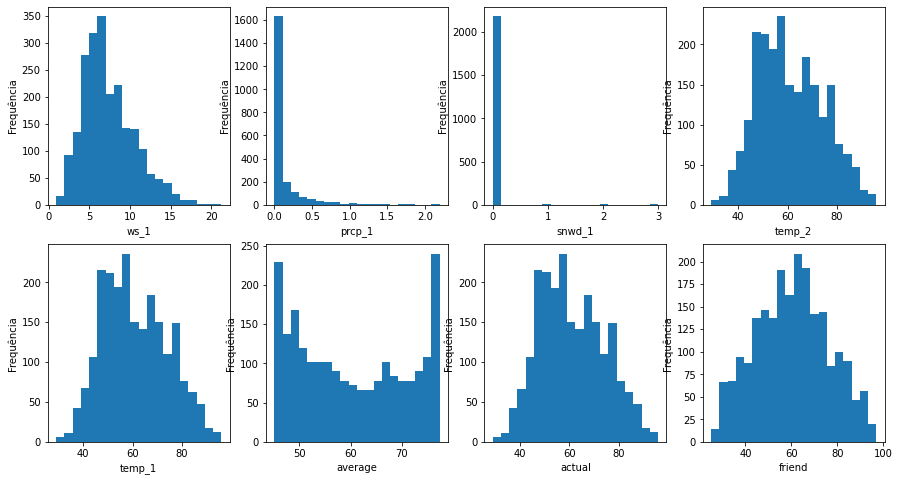

In [7]:
contColNames = list(df.drop(['year','month','day'], axis=1).select_dtypes(include='number').columns) #-> seleciona apenas colunas numéricas
ncols = 4 #-> número de colunas que armazenarão os plots na figure 
nrows = int(np.ceil(len(contColNames)/(1.0 * ncols))) #-> número de linhas que armazenarão os plots na figure 


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))

counter = 0 

for i in range(nrows):
  for j in range(ncols):

    ax = axes[i][j]

    # Plotar somente quando houver dados
    if counter < len(contColNames):

      ax.hist(df.drop(['year','month','day'], axis=1).select_dtypes(include='number')[contColNames[counter]], bins=20)
      ax.set_xlabel(contColNames[counter])
      ax.set_ylabel('Frequência')

    else:
      ax.set_axis_off()

    counter += 1

plt.show()

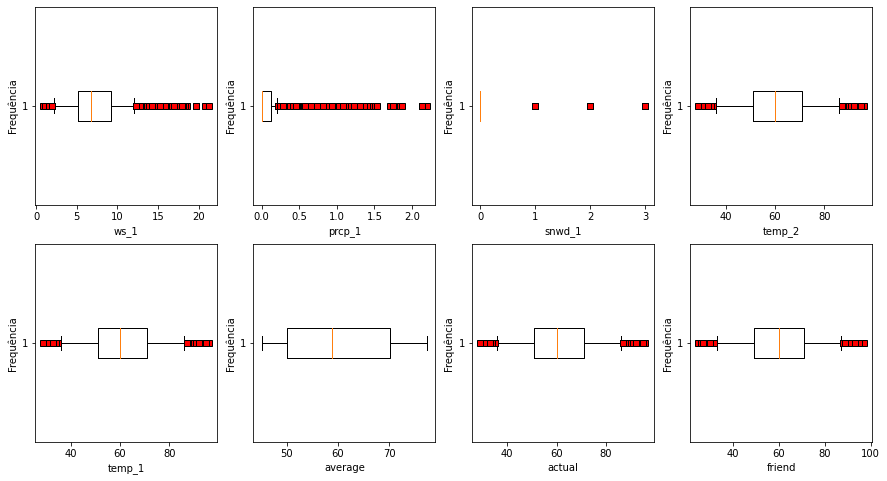

In [8]:
contColNames = list(df.drop(['year','month','day'], axis=1).select_dtypes(include='number').columns) #-> seleciona apenas colunas numéricas
ncols = 4 #-> número de colunas que armazenarão os plots na figure 
nrows = int(np.ceil(len(contColNames)/(1.0 * ncols))) #-> número de linhas que armazenarão os plots na figure 


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))

counter = 0 

for i in range(nrows):
  for j in range(ncols):

    ax = axes[i][j]

    # Plotar somente quando houver dados
    if counter < len(contColNames):
      red_square = dict(markerfacecolor='r', marker='s')
      ax.boxplot(df.drop(['year','month','day'], axis=1).select_dtypes(include='number')[contColNames[counter]], flierprops=red_square, vert=False, whis=0.75)
      ax.set_xlabel(contColNames[counter])
      ax.set_ylabel('Frequência')

    else:
      ax.set_axis_off()

    counter += 1

plt.show()

De imediato, podemos notar que não aparecem pontos que indiquem anomalias e não foram verificados registros nulos ou de '0' nas colunas. Por hora isso apresenta uma boa qualidade dos dados, mas um outro método de complementar esses insights é através de análise gráfica para verificar o comportamento da série temporal

In [9]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = df['year']
months = df['month']
days = df['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt


# Set the style
plt.style.use('fivethirtyeight')

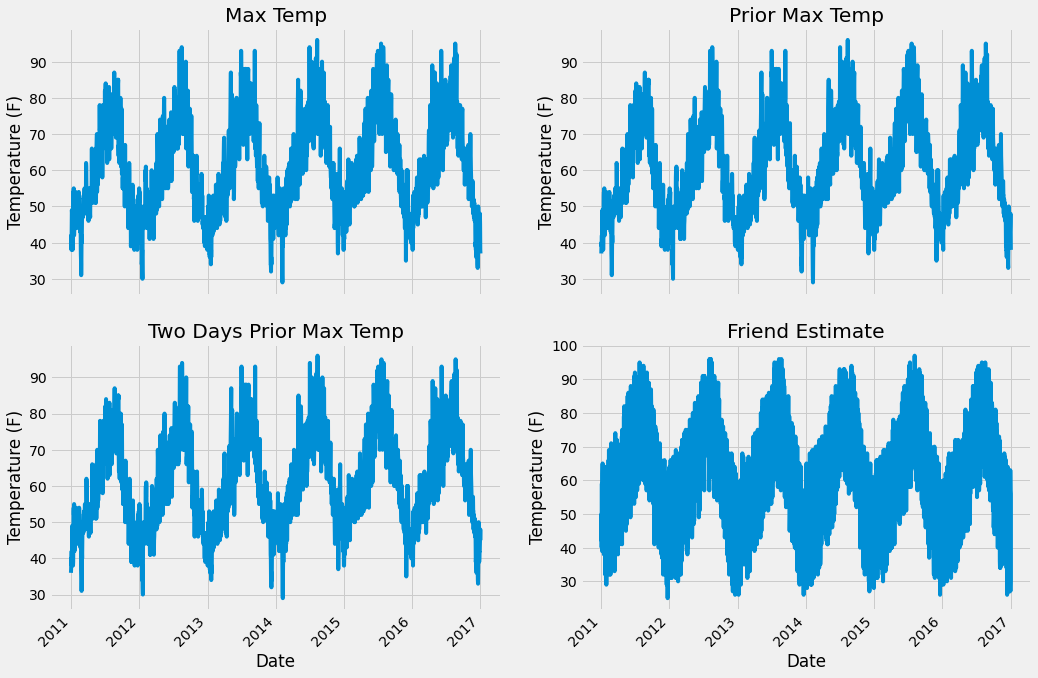

In [10]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, df['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, df['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); ax2.set_title('Prior Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, df['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, df['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature (F)'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

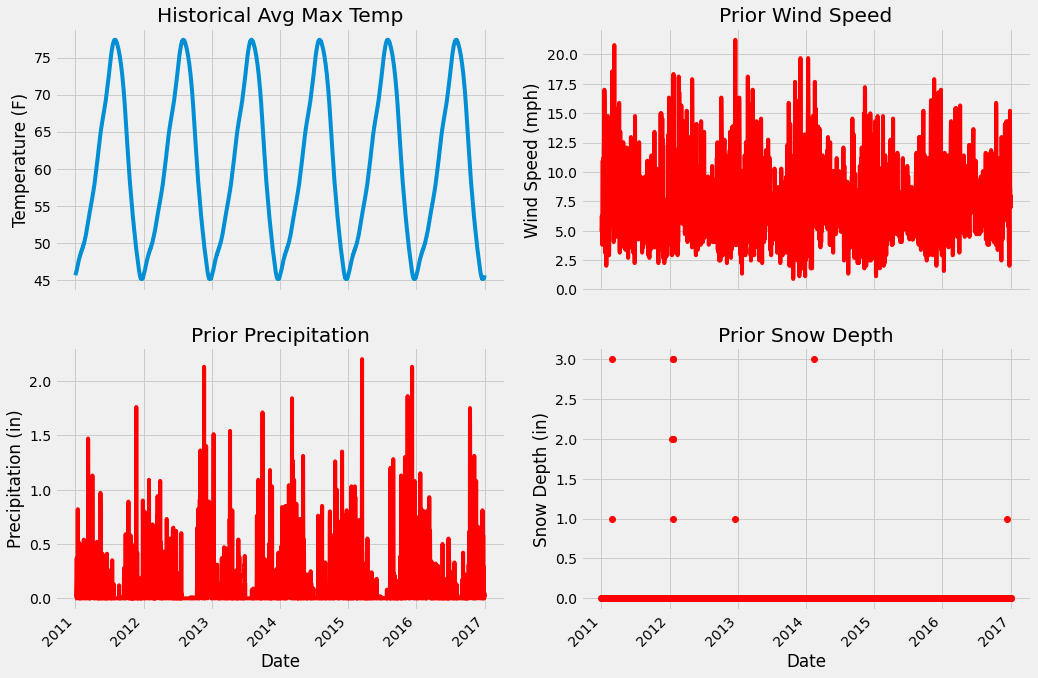

In [11]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Historical Average Max Temp
ax1.plot(dates, df['average'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Historical Avg Max Temp')

# Prior Avg Wind Speed 
ax2.plot(dates, df['ws_1'], 'r-')
ax2.set_xlabel(''); ax2.set_ylabel('Wind Speed (mph)'); ax2.set_title('Prior Wind Speed')

# Prior Precipitation
ax3.plot(dates, df['prcp_1'], 'r-')
ax3.set_xlabel('Date'); ax3.set_ylabel('Precipitation (in)'); ax3.set_title('Prior Precipitation')

# Prior Snowdepth
ax4.plot(dates, df['snwd_1'], 'ro')
ax4.set_xlabel('Date'); ax4.set_ylabel('Snow Depth (in)'); ax4.set_title('Prior Snow Depth')

plt.tight_layout(pad=2)

Podemos perceber que, apesar de alguns pontos ausentes (gaps), a variação da temperatura parece bastante factível ao ponto de não considerarmos anomalias nos dados.

> Pairplot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


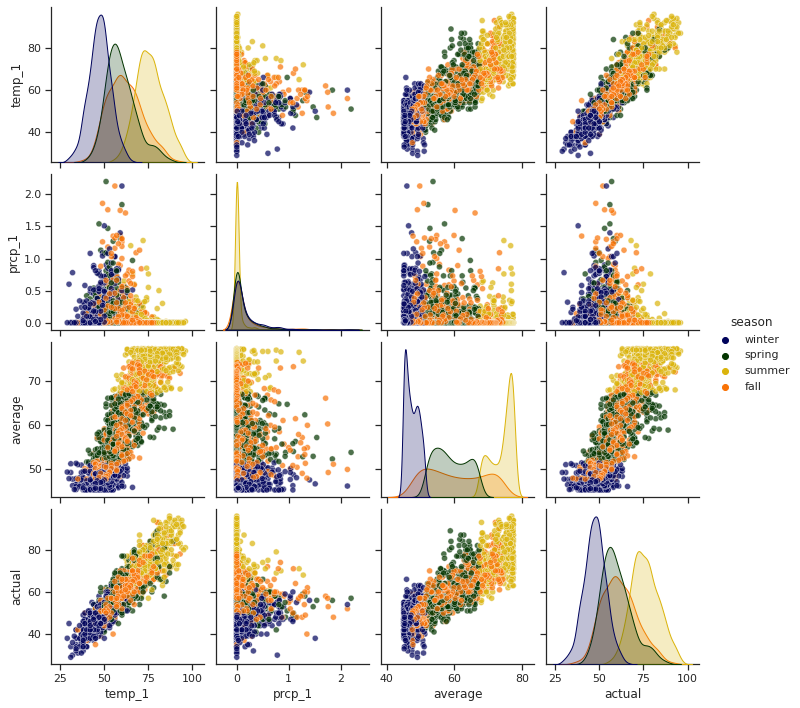

In [12]:
# Create columns of seasons for pair plotting colors
seasons = []

for month in df['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')

# Will only use six variables for plotting pairs
reduced_features = df[['temp_1', 'prcp_1', 'average', 'actual']]
reduced_features['season'] = seasons
# Use seaborn for pair plots
import seaborn as sns
sns.set(style="ticks", color_codes=True);

# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# Make the pair plot with a some aesthetic changes
sns.pairplot(reduced_features, hue = 'season', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True)); 

In [13]:
reduced_features.head()

,temp_1,prcp_1,average,actual,season
0,37,0.00,45.6,40,winter
1,40,0.00,45.7,39,winter
2,39,0.00,45.8,42,winter
3,42,0.00,45.9,38,winter
4,38,0.03,46.0,45,winter


> Correlação das variáveis

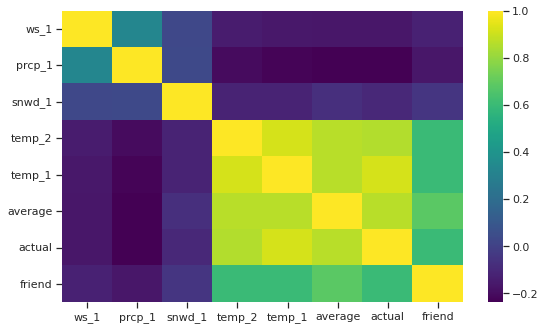

In [14]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.heatmap(df.drop(['year','month','day'], axis=1).corr(), annot=False, cmap='viridis')

# 4- Data Preparation

Infelizmente, não estamos no ponto em que você pode simplesmente alimentar dados brutos em um modelo e fazer com que ele retorne uma resposta (embora as pessoas estejam trabalhando nisso)! Precisaremos fazer algumas pequenas modificações para colocar nossos dados em termos compreensíveis para a máquina.

Os procedimentos ideias para a etapa de preparação dos dados vão depender muito do modelo que será implementado e dos dados coletados, mas a manipulação dos mesmos será requisito para qualquer aplicação de machine learning

> One-Hot Encoding: olhando para os dias da semana

In [23]:
dfw = df.weekday
dfw

0         Sat
1         Sun
2         Mon
3        Tues
4         Wed
        ...  
2186      Wed
2187    Thurs
2188      Fri
2189      Sat
2190      Sun
Name: weekday, Length: 2191, dtype: object

In [24]:
dfw_Dum = pd.get_dummies(dfw)
dfw_Dum

,Fri,Mon,Sat,Sun,Thurs,Tues,Wed
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2186,0,0,0,0,0,0,1
2187,0,0,0,0,1,0,0
2188,1,0,0,0,0,0,0
2189,0,0,1,0,0,0,0


In [25]:
dfs = reduced_features.season
dfs

0       winter
1       winter
2       winter
3       winter
4       winter
         ...  
2186    winter
2187    winter
2188    winter
2189    winter
2190    winter
Name: season, Length: 2191, dtype: object

In [26]:
dfs_Dum = pd.get_dummies(dfs)
dfs_Dum

,fall,spring,summer,winter
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
2186,0,0,0,1
2187,0,0,0,1
2188,0,0,0,1
2189,0,0,0,1


> Criando a matriz geral das features (X) e a resposta (y)

In [27]:
X = pd.concat([df.drop(['year','month','day','weekday','actual','friend'],axis=1).reset_index(drop=True), dfw_Dum, dfs_Dum], axis=1)
X

,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,fall,spring,summer,winter
0,4.92,0.00,0,36,37,45.6,0,0,1,0,0,0,0,0,0,0,1
1,5.37,0.00,0,37,40,45.7,0,0,0,1,0,0,0,0,0,0,1
2,6.26,0.00,0,40,39,45.8,0,1,0,0,0,0,0,0,0,0,1
3,5.59,0.00,0,39,42,45.9,0,0,0,0,0,1,0,0,0,0,1
4,3.80,0.03,0,42,38,46.0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,15.21,0.05,0,42,44,45.3,0,0,0,0,0,0,1,0,0,0,1
2187,8.72,0.00,0,44,47,45.3,0,0,0,0,1,0,0,0,0,0,1
2188,8.50,0.05,0,47,48,45.4,1,0,0,0,0,0,0,0,0,0,1
2189,6.93,0.02,0,48,45,45.5,0,0,1,0,0,0,0,0,0,0,1


> Análise de inflação de X

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Variance of Inflation

pd.DataFrame({
            'variables': X.columns[1:],
            'VIF': [variance_inflation_factor(X.values, i+1) for i in range(len(X.columns[1:]))]
            })

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,prcp_1,1.186941
1,snwd_1,1.030703
2,temp_2,7.565032
3,temp_1,7.584740
4,average,7.679218
5,Fri,inf
6,Mon,inf
7,Sat,inf
8,Sun,inf
9,Thurs,inf


Naturalmente variáveis categóricas ou que passaram por um processo de One-Hot Encoding não apresentarão um valor de VIF. Por hora iremos nos atentar à média da temperatura máxima (average) e às temperaturas registradas 1 e 2 dias antes (temp_1, temp_2), pois indicam os maiores VIFs. Entretanto daremos continuidade e se necessário iremos retirá-las para otimizar o modelo posteriormente.

In [29]:
y = df.actual
y

0       40
1       39
2       42
3       38
4       45
        ..
2186    47
2187    48
2188    45
2189    38
2190    37
Name: actual, Length: 2191, dtype: int64

> Testes de normalidade da resposta

In [30]:
import scipy as sp

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Resposta y \n Estatística do teste: 1.0\nP-Value: 0.0')

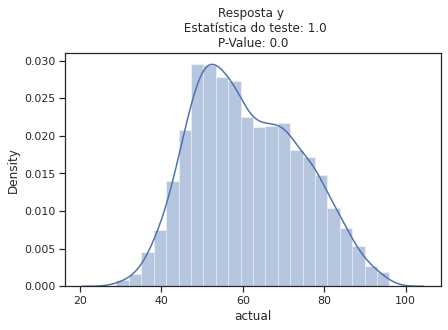

In [31]:
# Teste de Kolmogorov
kStat, kPvalue = sp.stats.kstest(rvs=y, cdf='norm') #cdf: cumulative distribution function ; <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

fig = plt.figure()
sns.distplot(y)
plt.title(f'Resposta y \n Estatística do teste: {kStat}\nP-Value: {kPvalue}')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Resposta log(y) \n Estatística do teste: 0.9996204539434627\nP-Value: 0.0')

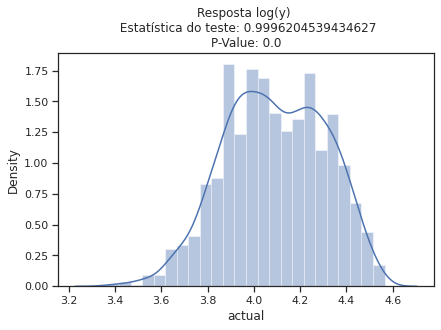

In [32]:
# Teste de Kolmogorov
kStat, kPvalue = sp.stats.kstest(rvs=np.log(y), cdf='norm') #cdf: cumulative distribution function ; <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

fig = plt.figure()
sns.distplot(np.log(y))
plt.title(f'Resposta log(y) \n Estatística do teste: {kStat}\nP-Value: {kPvalue}')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Resposta 1/y \n Estatística do teste: 0.5041555736026133\nP-Value: 0.0')

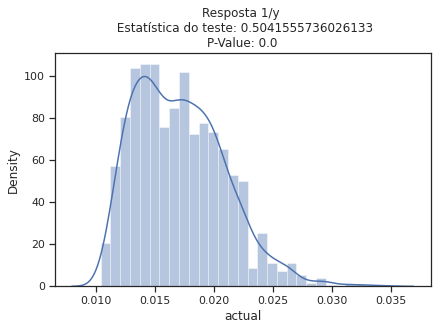

In [33]:
# Teste de Kolmogorov
kStat, kPvalue = sp.stats.kstest(rvs=1/y, cdf='norm') #cdf: cumulative distribution function ; <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

fig = plt.figure()
sns.distplot(1/y)
plt.title(f'Resposta 1/y \n Estatística do teste: {kStat}\nP-Value: {kPvalue}')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Resposta sqrt(y) \n Estatística do teste: 0.9999999638108507\nP-Value: 0.0')

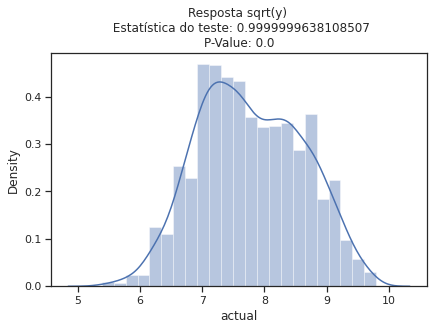

In [34]:
# Teste de Kolmogorov
kStat, kPvalue = sp.stats.kstest(rvs=np.sqrt(y), cdf='norm') #cdf: cumulative distribution function ; <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

fig = plt.figure()
sns.distplot(np.sqrt(y))
plt.title(f'Resposta sqrt(y) \n Estatística do teste: {kStat}\nP-Value: {kPvalue}')

In [35]:
posdata = y[y > 0] # Find the optimal Box-Cox transformation, and verify that λ is positive. This work-around doesn't work if λ ≤ 0.

yBx = sp.stats.boxcox(df['actual'], alpha = 0.01) # alpha = 0.01 for 99% of confidence

print('Optimal Box-Cox Transformation: ', yBx[1])
print('Confidence Interval (99%): ', yBx[2])

Optimal Box-Cox Transformation:  0.3053878594283542
Confidence Interval (99%):  (0.06676624805723631, 0.5460038654727195)


Com esses resultados existem duas possibilidades de melhorar o resultado: (1) usar o valor do lambda ótimo, de aprox. 0.305, ou (2) usar um valor que esteja dentro do intervalo de confiança. Neste caso, ambos '0' e '0.5' estão no intervalo. O valor nulo equivale ao logaritmo natural (que já foi testado) e o valor '0.5' representa a raiz quadrada da resposta

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Resposta Box-Cox para y^0.3054 \n Estatística do teste: 0.9974161940045264\nP-Value: 0.0')

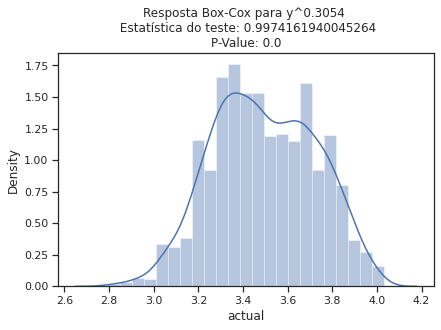

In [36]:
lambda_bx = yBx[1]

# Teste de Kolmogorov
kStat, kPvalue = sp.stats.kstest(rvs=(y**lambda_bx), cdf='norm') #cdf: cumulative distribution function ; <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

fig = plt.figure()
sns.distplot(y**lambda_bx)
plt.title(f'Resposta Box-Cox para y^{round(lambda_bx,4)} \n Estatística do teste: {kStat}\nP-Value: {kPvalue}')

Como não tivemos muitas melhorias com as transformações aplicadas à resposta, iremos manter os valores originais de y. A próxima etapa será a de dividir nosso conjunto de dados em treino e teste

In [37]:
# Training and Testing Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1643, 17)
(548, 17)
(1643,)
(548,)


# Random Forest Regression

> Train

Depois de todo o trabalho de preparação de dados, criar e treinar o modelo é bem simples usando o Scikit-learn. Importamos o modelo de regressão por RandomForest, instanciamos o modelo e fazemos o fit cos dados de treinamento.

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

> Predictions

Na etapa anterior o modelo foi treinado para aprender as relações entre Features (X) e o nosso target (y). O Próximo passo é avaliar as métricas do modelo passando os dados de teste e em seguida comparamos as previsões com as respostas conhecidas. Ao realizar a regressão, precisamos ter certeza de usar o erro absoluto porque esperamos que algumas de nossas respostas sejam baixas e outras altas. Estamos interessados em saber a distância entre nossa previsão média e o valor real, então pegamos o valor absoluto

In [39]:
y_pred = rf.predict(X_test)

from sklearn import metrics
# Calcular as métricas do modelo
errors = abs(y_pred - y_test)
mape = 100*(errors/y_test) #Mean Absolute Percentage Error
accuracy = 100 - np.mean(mape)

print("MAE: {}".format(metrics.mean_absolute_error(y_test,y_pred)))
print("RMSE: {}".format(metrics.mean_squared_error(y_test,y_pred, squared=True)))
print("R²: {}".format(metrics.r2_score(y_test,y_pred)))
print("Accuracy (%): {}".format(accuracy))

MAE: 3.8244543795620447
RMSE: 24.004369180656933
R²: 0.8521064339593578
Accuracy (%): 93.49927716999831


In [40]:
pred_DF = pd.DataFrame({'Temp_true' : y_test,
                        'Temp_pred' : y_pred,
                        'residuals' : y_test - y_pred})
pred_DF

,Temp_true,Temp_pred,residuals
382,32,41.451,-9.451
632,67,69.176,-2.176
1670,94,85.937,8.063
211,71,79.061,-8.061
1488,54,50.423,3.577
...,...,...,...
1502,62,54.272,7.728
1665,70,73.628,-3.628
817,65,59.202,5.798
904,70,70.027,-0.027


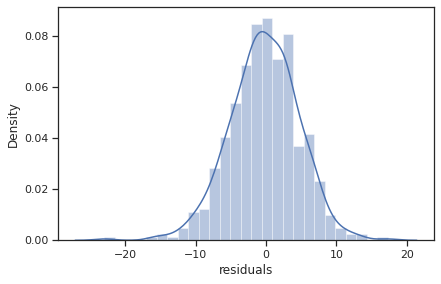

In [41]:
sns.distplot(pred_DF.residuals)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Residuals for Temperature')

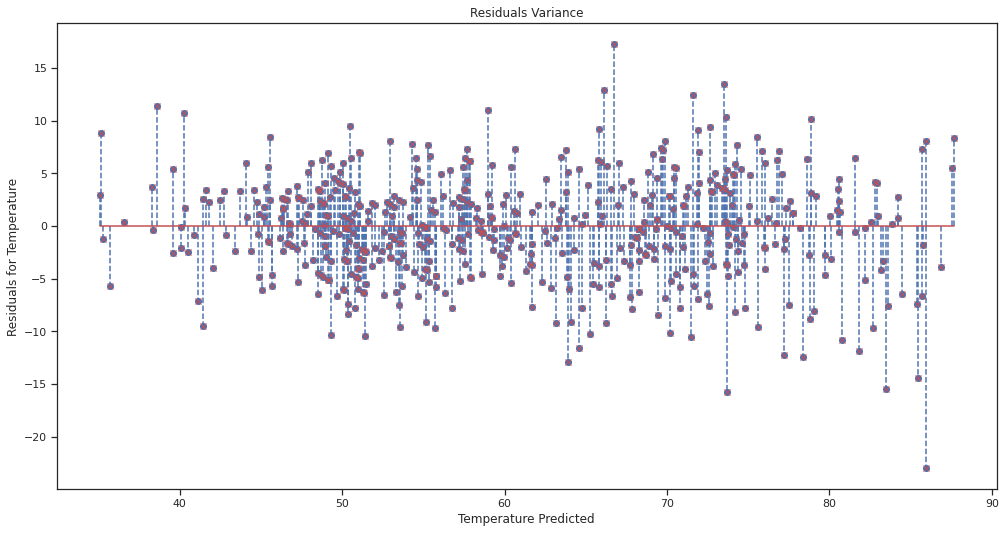

In [45]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.stem(pred_DF.Temp_pred, pred_DF.residuals,'--b')
plt.plot(pred_DF.Temp_pred, pred_DF.residuals,'xr')
ax.set_title('Residuals Variance')
ax.set_xlabel('Temperature Predicted')
ax.set_ylabel('Residuals for Temperature')

Da análise dos resíduos, podemos notar que o comportamento não aparenta ser mais uma variação aleatória do que algo heterocedástico (o que é bom, pois o modelo não teria uma tencência de overfit ou underfit). Além disso a distribuição dos resíduos é bem próxima de uma Gaussiana

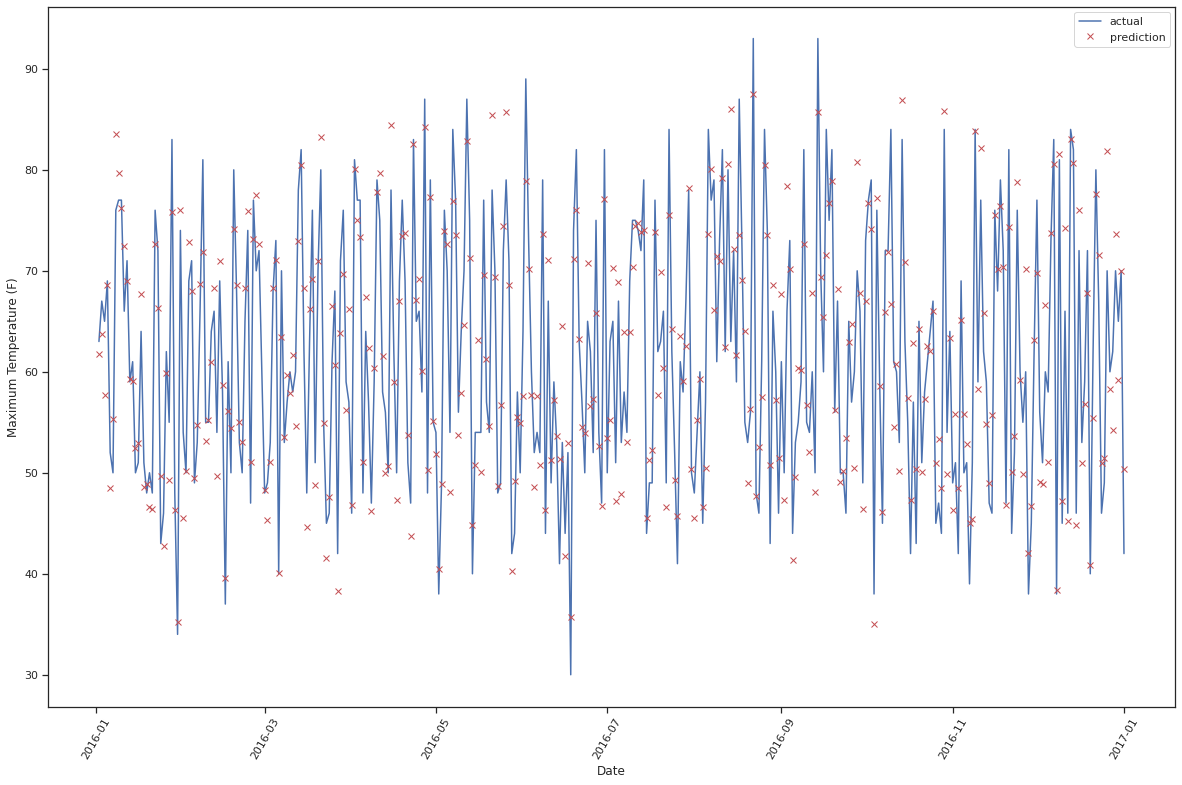

In [47]:
# Set up the plotting layout

# Actual max temperature measurement
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1,1,1)
plt.plot(dates[-365:], y_test[-365:],'b-', label = 'actual',linewidth=1.5)
plt.plot(dates[-365:], y_pred[-365:],'rx',label = 'prediction')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')

plt.xticks(rotation = '60')
plt.legend()

Relembrando nosso DF original e comparando com a métrica para os valores "friend"

In [48]:
df.tail(548) #Representaria a porção reservada para teste

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
1643,2015,7,3,Fri,7.61,0.00,0,90,93,73.5,92,77
1644,2015,7,4,Sat,5.82,0.00,0,93,92,73.8,92,58
1645,2015,7,5,Sun,6.49,0.00,0,92,92,74.0,91,73
1646,2015,7,6,Mon,4.70,0.00,0,92,91,74.2,85,94
1647,2015,7,7,Tues,7.16,0.00,0,91,85,74.4,81,64
...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2016,12,28,Wed,15.21,0.05,0,42,44,45.3,47,30
2187,2016,12,29,Thurs,8.72,0.00,0,44,47,45.3,48,63
2188,2016,12,30,Fri,8.50,0.05,0,47,48,45.4,45,57
2189,2016,12,31,Sat,6.93,0.02,0,48,45,45.5,38,56


In [49]:
print("MAE: {}".format(metrics.mean_absolute_error(df.actual.tail(548),df.friend.tail(548))))

MAE: 11.291970802919709


Isso parece muito bom! Nosso modelo aprendeu a prever a temperatura máxima para o dia seguinte em Seattle com cerca de 94% de precisão. 

Um MAE ~ 3.824 indica que o modelo erra, em média, 3.824 unidades na variável target (isto é, ele superestima ou sobrestima a temperatura nesse valor para cada valor real ou esperado). Isso é bem melhor que a baseline dos valores em "friend" - dependendo do campo de aplicação do problema isso pode representar milhões de dólares economizados por uma empresa

> Interpretando o Modelo e Reportando os Resultados

Até este ponto sabemos que nosso modelo parece bom, mas ele é praticamente uma caixa preta (fornecemos como input alguns arrays para treinamento, pedimos um ajuste destes pontos, avaliamos as previsões e verificamos se elas são razoáveis através das métricas). A questão é como o modelo lida com esses valores, isto é, como ele chega nas respostas finais?

Basicamente existem duas abordagens para olhar "por de baixo dos panos" de um Random Forest Regressor: (1) podemos olhar para uma árvore isolada e entender as relações entre cada feature e o target ou (2) podemos olhar para a importância das nossas variáveis explicativas

In [ ]:
# One of the coolest parts of the Random Forest implementation in Skicit-learn
# is we can actually examine any of the trees in the forest. We will select one tree,
# and save the whole tree as an image. The following code takes one tree from the
# forest and saves it as an image.

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

Apenas para termos uma ideia da dimensão da nossa Forest, segue um trecho do print:


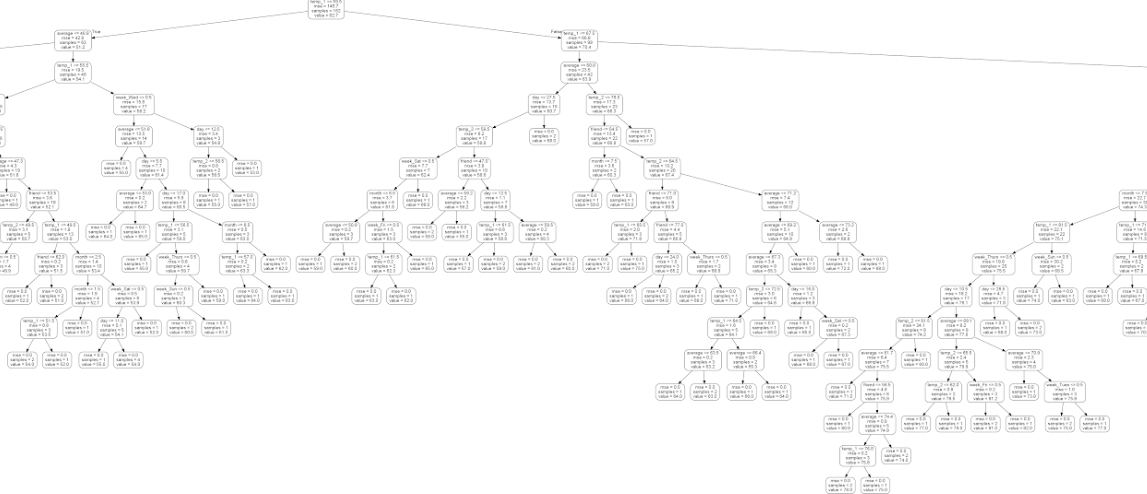

Para deixar mais simplificado, iremos limitar o hiperparâmetro max_depth que indica a profundidade de cada árvore afim de analisar uma imagem mais "entendível"

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = list(X.columns), rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

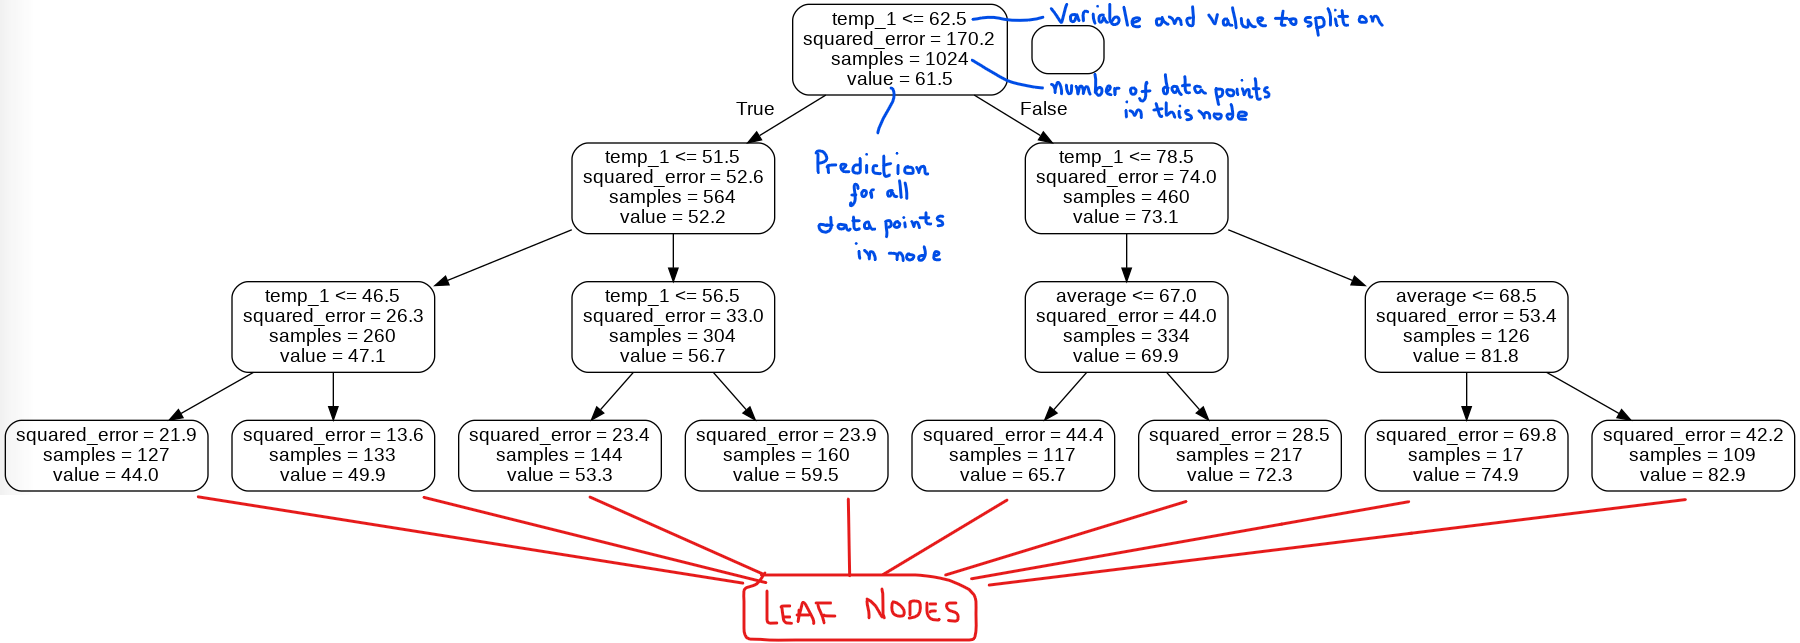

In [52]:
df.iloc[2186]

year        2016
month         12
day           28
weekday      Wed
ws_1       15.21
prcp_1      0.05
snwd_1         0
temp_2        42
temp_1        44
average     45.3
actual        47
friend        30
Name: 2186, dtype: object

Com base apenas nessa árvore, podemos fazer uma previsão para qualquer nova combinação de dados. Vamos dar um exemplo de como fazer uma previsão para quarta-feira, 28 de dezembro de 2016:

As variáveis (reais) são:

- ws_1   =    15.21
- prcp_1  =    0.05
- snwd_1   =      0
- temp_2   =     42
- temp_1   =     44
- average  =   45.3

Começamos com o root node (raiz) e o primeiro booleano é True, pois `temp_1 < 62.5`. Logo nos movemos para a esquerda e encontramos a segunda pergunta, que também terá resposta verdadeira. Descendo para a esquerda e para a terceira e última pergunta que também retorna True, pois `temp_1 < 46.5`. Portanto concluímos que nossa estimativa para a temperatura máxima é 44 como um valor indicado na leaf node.

Uma observação interessante é que a root node apresenta apenas 1024 amostras apesar de existirem originalmente 1643 pontos de dados de treinamento. Isso é explicado porque em cada árvore na nossa Random Forest é treinada em um subconjunto aleatório dos dados com substituição (técnica chamada bagging, short for bootstrap aggregating: <https://en.wikipedia.org/wiki/Bootstrap_aggregating>)

Além disso, observe que em nossa árvore, existem apenas 2 variáveis que realmente usamos para fazer uma previsão. De acordo com essa árvore de decisão específica, todas as Features restantes não são importante para fazer uma previsão. Mês do ano e dia do mês, por exemplo, são totalmente inúteis para prever a temperatura máxima amanhã! A única informação importante de acordo com nossa árvore simples é a temperatura do dia anterior e a média histórica.

> Importância das variáveis

Para quantificar a utilidade de todas as variáveis em toda nossa Random Forest, podemos observar as importâncias relativas de cada Feature. As importâncias retornadas pelo Skicit-learn representam o quanto a inclusão de uma variável específica melhora a previsão. O cálculo real da importância está além do escopo deste estudo, mas podemos usar os números para fazer comparações relativas entre variáveis.

In [53]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.84
Variable: average              Importance: 0.07
Variable: ws_1                 Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: prcp_1               Importance: 0.01
Variable: snwd_1               Importance: 0.0
Variable: Fri                  Importance: 0.0
Variable: Mon                  Importance: 0.0
Variable: Sat                  Importance: 0.0
Variable: Sun                  Importance: 0.0
Variable: Thurs                Importance: 0.0
Variable: Tues                 Importance: 0.0
Variable: Wed                  Importance: 0.0
Variable: fall                 Importance: 0.0
Variable: spring               Importance: 0.0
Variable: summer               Importance: 0.0
Variable: winter               Importance: 0.0


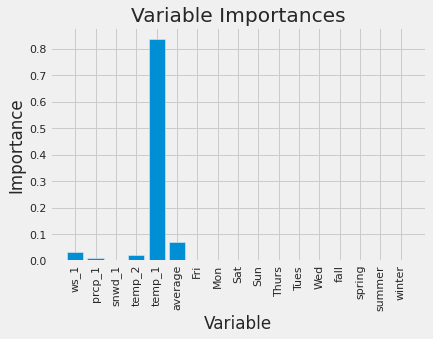

In [54]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, list(X.columns), rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

No topo da lista está temp_1, a temperatura máxima do dia anterior. Isso nos diz que o melhor preditor da temperatura máxima para um dia é a temperatura máxima do dia anterior, uma descoberta bastante intuitiva. O segundo fator mais importante é a temperatura máxima média histórica, também não tão surpreendente. Todas essas importâncias fazem sentido, pois não esperaríamos por exemplo que o dia da semana fosse um preditor da temperatura máxima, pois não tem nada a ver com o clima

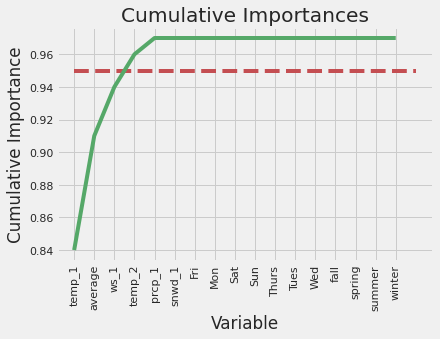

In [55]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');